# Architectural Tradeoff Analysis (PCA)

In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
from adjustText import adjust_text
from pcatools import *
from tabulate import tabulate
import os
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math
import plotly.graph_objects as go
import plotly.subplots as sp
from matplotlib.text import Text

In [2]:
path = "C:/Users/KOQVIST1/architectural-tradeoff-analysis/Simulation data/"
filedir = "April13/combined.csv"
df = pd.DataFrame(pd.read_csv((path+filedir)))

full_length = len(df)

# Clean data by dropping inf values (and NaN)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop_duplicates()

cleaned_length = len(df)

number_of_topologies = len([x for x in df.columns if x[0].isdigit()])

## Data Display

### Filtering data per Topology

Filtered out 1012 rows of data


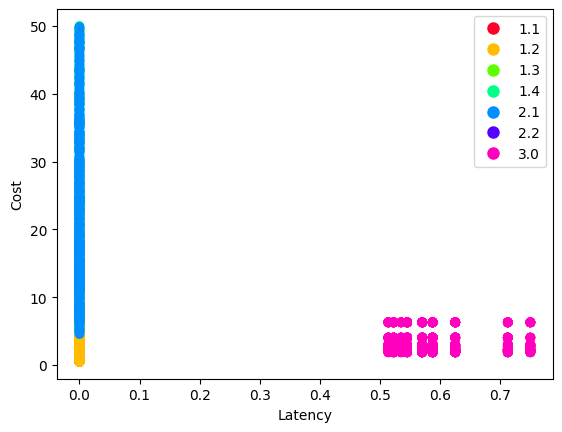

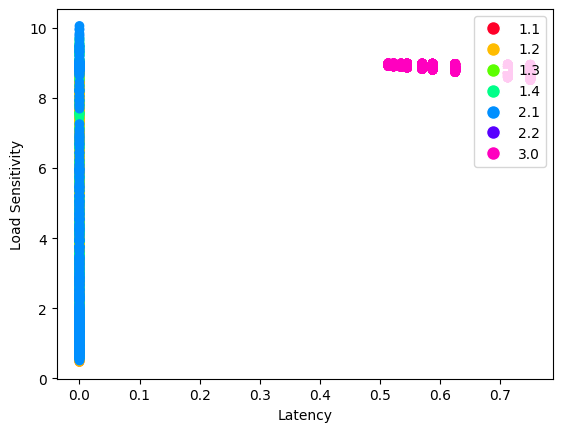

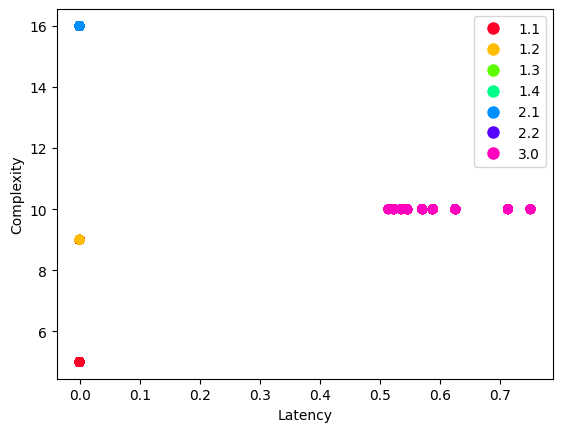

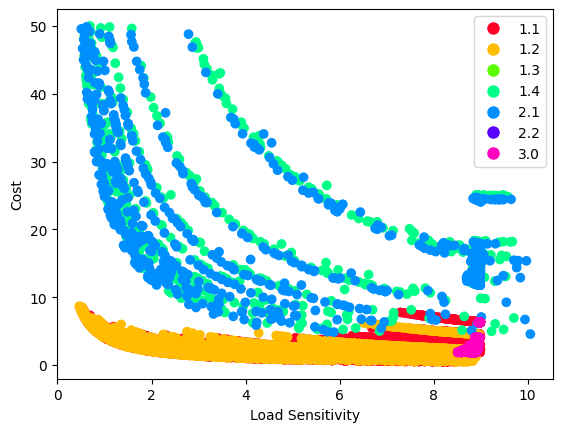

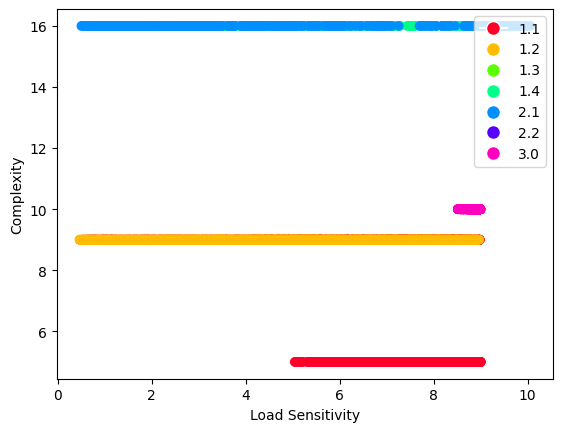

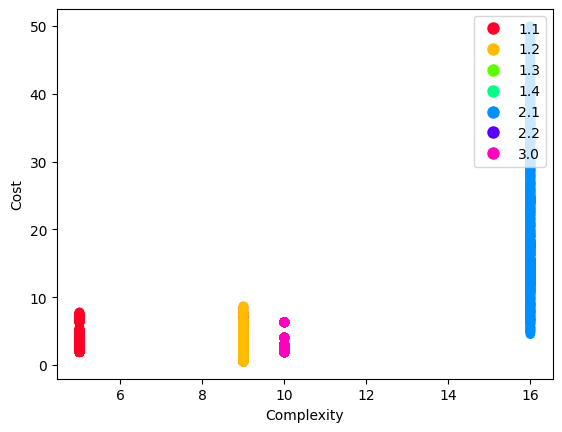

"for i, topo in enumerate(topologies) :\n    topo_filter = df_filtered.Topology == topo\n    df_filtered_topo = df_filtered[topo_filter].reset_index(drop=True)\n    if (len(df_filtered_topo)) > 0 :\n        #topoScatterPrint(df_filtered_topo, 'Latency','Cost', False)\n        #topoScatterPrint(df_filtered_topo, 'latency','scalability', False)\n        #topoScatterPrint(df_filtered_topo, 'latency','complexity', False)\n        #topoScatterPrint(df_filtered_topo, 'scalability','cost', False)\n        #topoScatterPrint(df_filtered_topo, 'scalability','complexity', False)\n        #topoScatterPrint(df_filtered_topo, 'complexity','cost', False)"

In [3]:
topology_names       =    ["Simple_1","Simple_2","Simple_3","Simple_4","Stream_1","Stream_2","Sophisticated_1"]
topologies           =    [1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 3.0]
latency_uplims       =    [None,None,None,None,None,None,None]
latency_lowlims      =    [None,None,None,None,None,None,None]
cost_uplims          =    [50,50,50,50,50,50,50]
cost_lowlims         =    [None,None,None,None,None,None,None]
complexity_uplims    =    [None,None,None,None,None,None,None]
complexity_lowlims   =    [None,None,None,None,None,None,None]
loadsensitivity_uplims   =    [None,None,None,None,None,None,None]
loadsensitivity_lowlims  =    [None,None,None,None,None,None,None]

df_filtered = filterData(df, topologies,latency_uplims,latency_lowlims,cost_uplims,cost_lowlims,
                        complexity_uplims,complexity_lowlims,loadsensitivity_uplims,loadsensitivity_lowlims)

topoScatterPrint(df_filtered, 'Latency','Cost', False)
topoScatterPrint(df_filtered, 'Latency','Load Sensitivity', False)
topoScatterPrint(df_filtered, 'Latency','Complexity', False)
topoScatterPrint(df_filtered, 'Load Sensitivity','Cost', False)
topoScatterPrint(df_filtered, 'Load Sensitivity','Complexity', False)
topoScatterPrint(df_filtered, 'Complexity','Cost', False)

"""for i, topo in enumerate(topologies) :
    topo_filter = df_filtered.Topology == topo
    df_filtered_topo = df_filtered[topo_filter].reset_index(drop=True)
    if (len(df_filtered_topo)) > 0 :
        #topoScatterPrint(df_filtered_topo, 'Latency','Cost', False)
        #topoScatterPrint(df_filtered_topo, 'latency','scalability', False)
        #topoScatterPrint(df_filtered_topo, 'latency','complexity', False)
        #topoScatterPrint(df_filtered_topo, 'scalability','cost', False)
        #topoScatterPrint(df_filtered_topo, 'scalability','complexity', False)
        #topoScatterPrint(df_filtered_topo, 'complexity','cost', False)"""

### Optimizing Data for all topologies

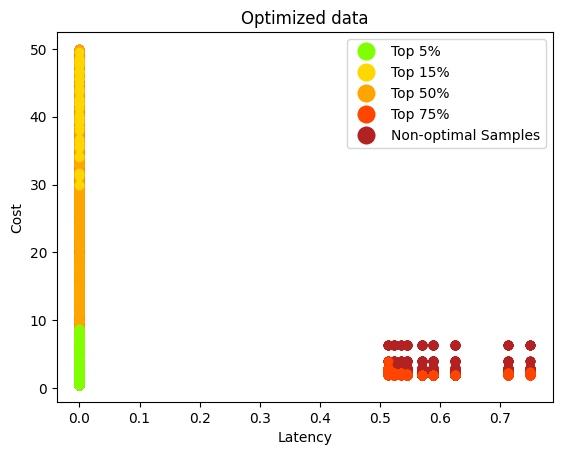

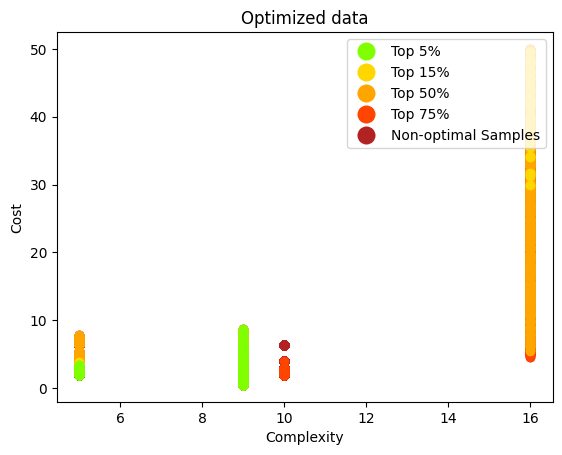

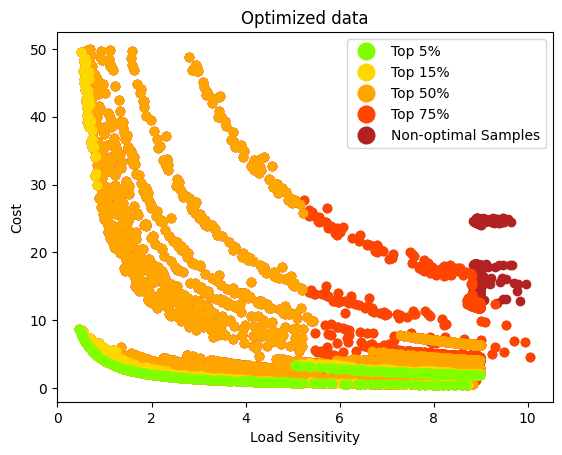

In [4]:
pareto_targets = ['Latency', 'Cost','Complexity','Load Sensitivity']
pareto_objectives = ["min", "min","min","min"]
df_opt_5 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.05)
df_opt_15 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.15)
df_opt_50 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.5)
df_opt_75 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.75)

printParetoOpt(df_filtered, df_opt_5, df_opt_15, df_opt_50, df_opt_75, False, "Optimized data")


### Optimising data for each topology individually

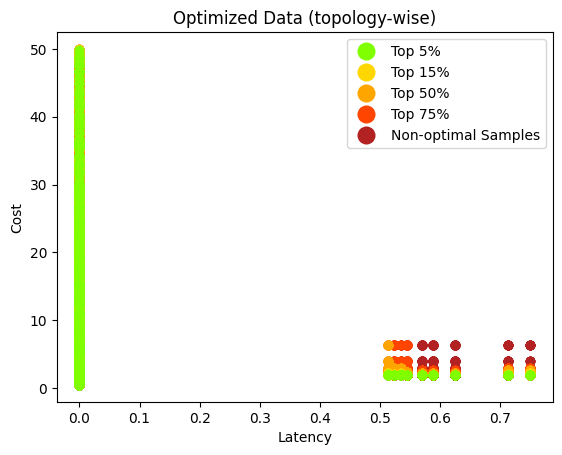

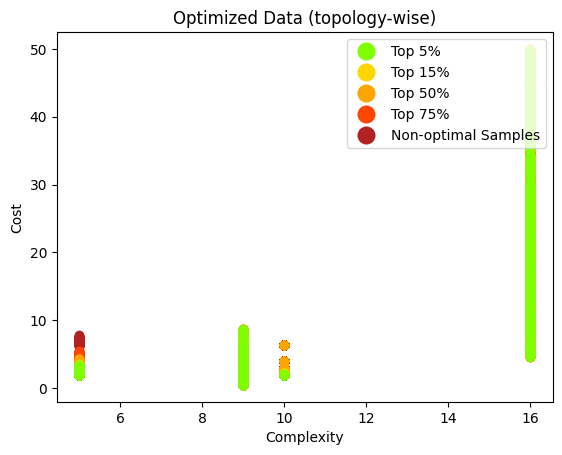

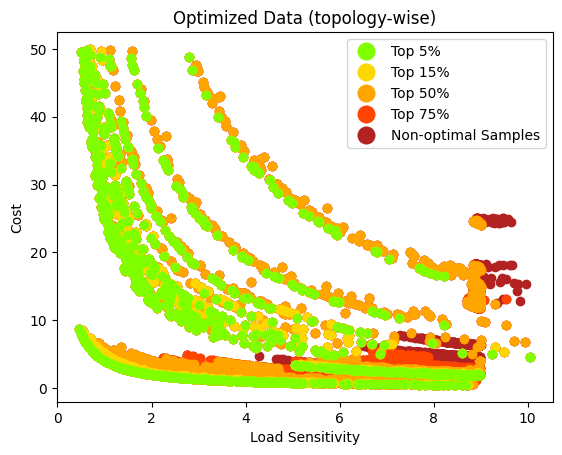

In [5]:
pareto_targets = ['Latency', 'Cost','Complexity','Load Sensitivity']
pareto_objectives = ["min", "min","min","min"]

df_t_opt_5 = pd.DataFrame()
df_t_opt_15 = pd.DataFrame()
df_t_opt_50 = pd.DataFrame()
df_t_opt_75 = pd.DataFrame()
for i, topo in enumerate(topologies) :
    topo_filter = df_filtered.Topology == topo
    df_temp_5 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.05)
    df_temp_15 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.15)
    df_temp_50 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.5)
    df_temp_75 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.75)
    df_t_opt_5 = pd.concat([df_t_opt_5,df_temp_5])
    df_t_opt_15 = pd.concat([df_t_opt_15,df_temp_15])
    df_t_opt_50 = pd.concat([df_t_opt_50,df_temp_50])
    df_t_opt_75 = pd.concat([df_t_opt_75,df_temp_75])
    

printParetoOpt(df_filtered, df_t_opt_5, df_t_opt_15, df_t_opt_50, df_t_opt_75, False, "Optimized Data (topology-wise)")


# 1: Choosing Topology

### Radar Plots

           Latency      Cost  Complexity  Load Sensitivity
Topology                                                  
1.1       1.000357  1.195202         1.0          4.981677
1.2       1.000009  1.291238         1.0          4.521792
1.3       1.000323  0.846553         2.6          2.955767
1.4       1.000013  0.974168         2.6          2.505397
2.1       1.000487  3.112926         5.4          3.986428
2.2       1.008394  3.097115         5.4          3.857588
3.0       4.773691  1.161758         3.0          5.191351


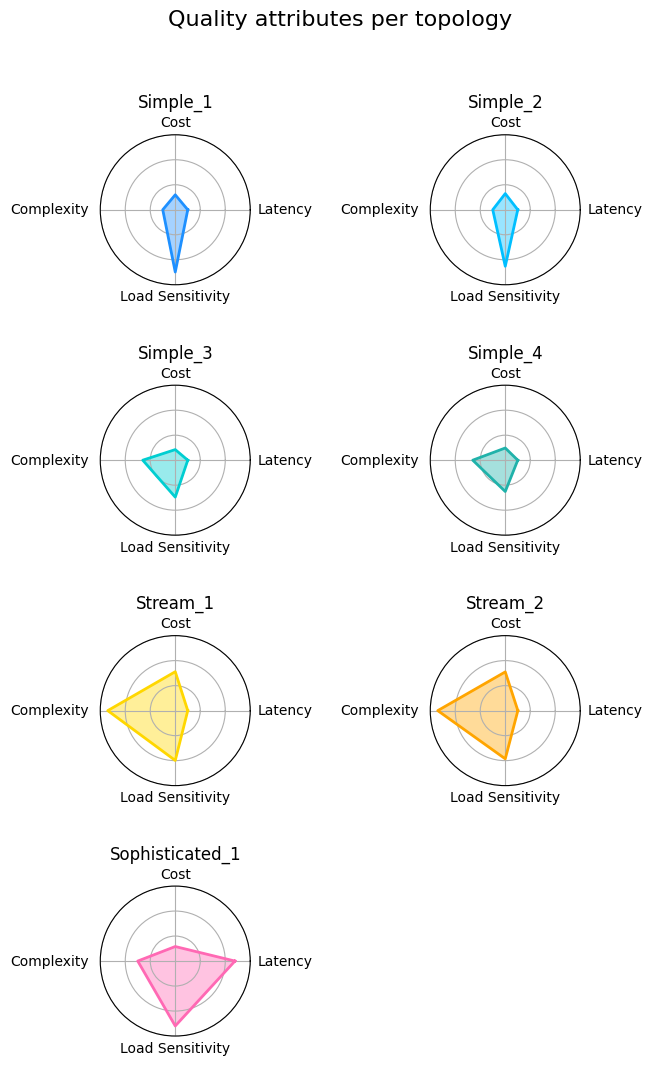

In [6]:
#df_ef = df_t_opt_5
df_ef = df_filtered
topologies = df_ef['Topology'].unique()
df_mean = pd.DataFrame()

df_mean = df_ef.groupby("Topology")[['Latency','Cost','Complexity','Load Sensitivity']].mean()

#df_mean['complexity'] = np.log(df_mean['complexity']).multiply(1)
df_mean['Complexity'] = df_mean['Complexity'].multiply(0.4).add(-1)
df_mean['Load Sensitivity']=(df_mean['Load Sensitivity']-df_mean['Load Sensitivity'].mean())/df_mean['Load Sensitivity'].std()
df_mean['Load Sensitivity'] = df_mean['Load Sensitivity'].add(4)
df_mean['Cost'] = np.log10(df_mean['Cost']).multiply(2.5)
df_mean['Latency'] = df_mean['Latency'].multiply(100000).add(10)
df_mean['Latency'] = np.log10(df_mean['Latency'])

print(df_mean)

fill_color = ["dodgerblue","deepskyblue","darkturquoise","lightseagreen", "gold", "orange","hotpink"];
"""printRadarPlots(df_mean.iloc[0:4], fill_color[0:4], 1 , 4, (-0.2,0.1,-0.42,0.1),(12,12))
printRadarPlots(df_mean.iloc[4:6], fill_color[4:6], 1 , 2, (-0.2,0.1,-0.42,0.1),(5.2,4))
printRadarPlots(df_mean.iloc[6:7], fill_color[6:7], 1 , 1, (-0.2,0.1,-0.42,0.1),(2,1.6))"""

printRadarPlots(df_mean, topology_names, fill_color, 4 , 2, (-0.2,0.1,-0.42,0.1),(6,12), "Quality attributes per topology")

### PCA Analysis

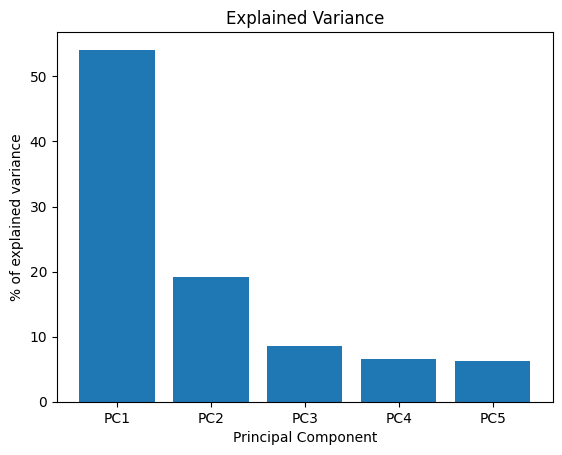

NameError: name 'colormap' is not defined

In [7]:
desired_cols = ["Simple_1","Simple_2","Simple_3","Simple_4","Stream_1","Stream_2","Sophisticated_1",'Latency','Cost','Complexity','Load Sensitivity']
df_topo = df_t_opt_15[desired_cols]

corr_topo = scaleData(df_topo).corr()
corr_topo = corr_topo.fillna(0)

# assign categories
buckets = [0] * len(df_topo.columns)
buckets[-4:] = [1, 1, 1,1]
categories = np.array(buckets)

pca, pca_data = createPCA(corr_topo)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_topo, 'PCA plot of Topologies and Quality metrics \n Top optimal 15% of the data ',categories=categories, colormap=colormap)

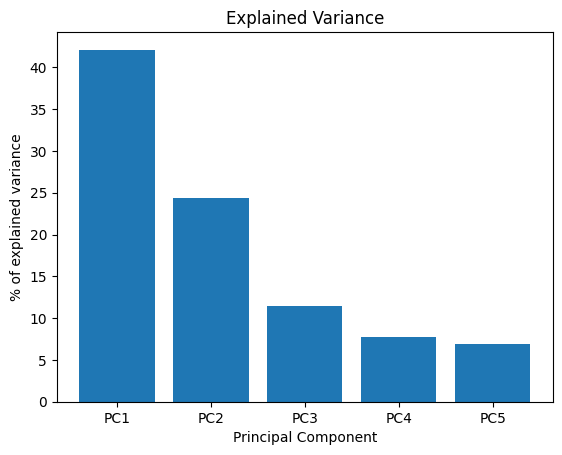

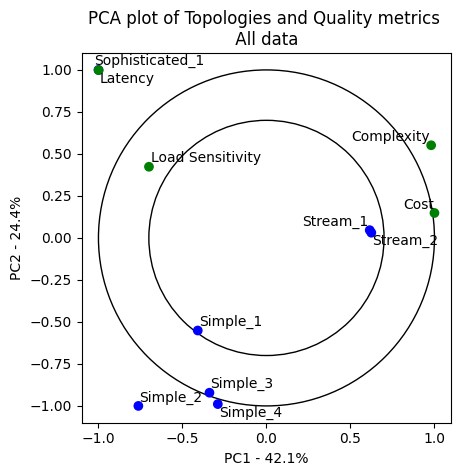

In [ ]:
desired_cols = ["Simple_1","Simple_2","Simple_3","Simple_4","Stream_1","Stream_2","Sophisticated_1",'Latency','Cost','Complexity','Load Sensitivity']
df_topo = df_filtered[desired_cols]

corr_topo = scaleData(df_topo).corr()
corr_topo = corr_topo.fillna(0)

# assign categories
buckets = [0] * len(df_topo.columns)
buckets[-4:] = [1, 1, 1,1]
categories = np.array(buckets)

pca, pca_data = createPCA(corr_topo)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_topo, 'PCA plot of Topologies and Quality metrics \n All data ',categories=categories, colormap=colormap)

### What topologies Optimize what?

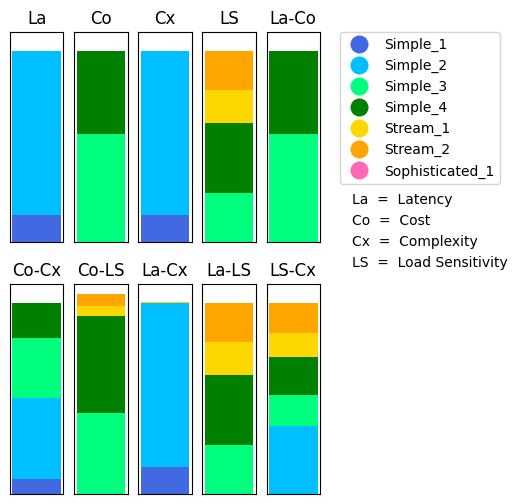

In [ ]:
"""pareto_target_pairs = [['Latency', 'Cost'],['Cost', 'Complexity'],['Cost','Load Sensitivity'],['Latency', 'Complexity'],['Latency', 'Load Sensitivity'],['Load Sensitivity', 'Complexity']]
pareto_objectives = ["min", "min"]

for i, pair in enumerate(pareto_target_pairs) :
    df_temp= paretoOptimize(df_filtered, pair , pareto_objectives,0.15)
    #print(pair,df_temp['Topology'].unique())
    print(pair,df_temp['Topology'].value_counts(sort=False).tolist(), df_temp['Topology'].value_counts(sort=False).index.tolist())"""

"""pareto_target_pairs = ['Latency', 'Cost','Complexity','Load Sensitivity']
pareto_objectives = ["min"]

for i, pair in enumerate(pareto_target_pairs) :
    df_temp= paretoOptimize(df_filtered, pair , pareto_objectives,0.15)
    print(pair,df_temp['Topology'].unique())
    print(pair,df_temp['Topology'].value_counts(sort=False),df_temp['Topology'].value_counts(sort=False).index.tolist())"""

"""pareto_objectives = ["min","min","min","min"]

df_temp= paretoOptimize(df_filtered, pareto_target_pairs, pareto_objectives,0.05)
print("All",df_temp['Topology'].unique())"""

colors = ["royalblue","deepskyblue","springgreen","green", "gold", "orange","hotpink"];
data = pd.DataFrame({
    'La': [236,1433,0,0,0,0,0],
    'Co': [0,0,945,724,0,0,0],
    'Cx': [240,1429,0,0,0,0,0],
    'LS': [0,0,426,612,291,340,0],
    'La-Co': [0,0,945,724,0,0,0],
    'Co-Cx': [134,701,531,304,0,0,0],
    'Co-LS': [0,0,708,842,90,106,0],
    'La-Cx': [236,1433,0,2,1,0,0],
    'La-LS': [0,0,426,613,291,340,0],
    'LS-Cx': [0,596,265,331,211,266,0],
})

printTopologyClusters(data,colors)

## Parameter influence on the quality

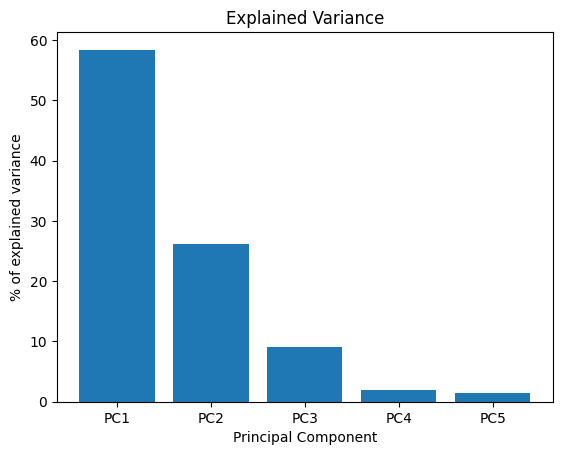

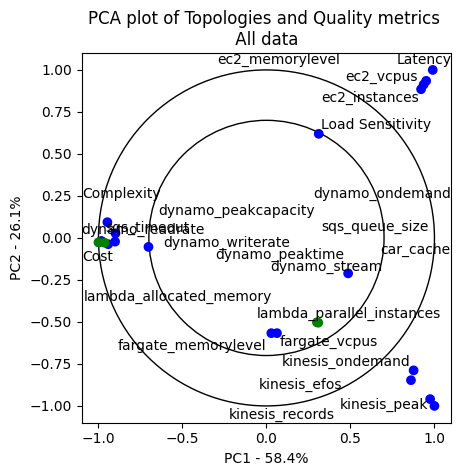

In [ ]:
desired_cols = np.setdiff1d(np.array(df_filtered.columns),np.array(["Topology","Simple_1","Simple_2","Simple_3","Simple_4","Stream_1","Stream_2","Sophisticated_1"]))
df_topo = df_filtered[desired_cols]

corr_topo = scaleData(df_topo).corr()
corr_topo = corr_topo.fillna(0)

buckets = [0] * len(df_topo.columns)
buckets[-4:] = [1, 1, 1, 1]
categories = np.array(buckets)

# assign categories
buckets = [0] * len(df_topo.columns)
buckets[-4:] = [1, 1, 1,1]
categories = np.array(buckets)

pca, pca_data = createPCA(corr_topo)
printScree(pca, 'Explained Variance')
#printTresholdPCA(pca, pca_data, corr_topo, 0.5, 'PCA plot of Topologies and Quality metrics \n All data ',categories=categories, colormap=colormap)
#printPCA(pca, pca_data, corr_topo, 'PCA plot of Topologies and Quality metrics \n All data ',categories=categories, colormap=colormap)
specialPCA(pca, pca_data, corr_topo)

In [ ]:
x_filtered = df_scaled.loc[['Latency','Cost', 'Complexity', 'Load Sensitivity']].PC1
x = df_scaled.drop(['Latency','Cost', 'Complexity', 'Load Sensitivity']).PC1

print(x)

car_cache                    0.486225
dynamo_ondemand             -0.898633
dynamo_peakcapacity         -0.981628
dynamo_peaktime             -0.901110
dynamo_readrate             -0.995950
dynamo_stream               -0.702310
dynamo_writerate            -0.984290
ec2_instances                0.920383
ec2_memorylevel              0.950785
ec2_vcpus                    0.935643
fargate_memorylevel          0.028895
fargate_vcpus                0.062657
kinesis_efos                 0.860277
kinesis_ondemand             0.875962
kinesis_peak                 0.974409
kinesis_records              1.000000
lambda_allocated_memory      0.300521
lambda_parallel_instances    0.308546
sqs_queue_size              -0.962773
sqs_timeout                 -1.000000
Name: PC1, dtype: float64


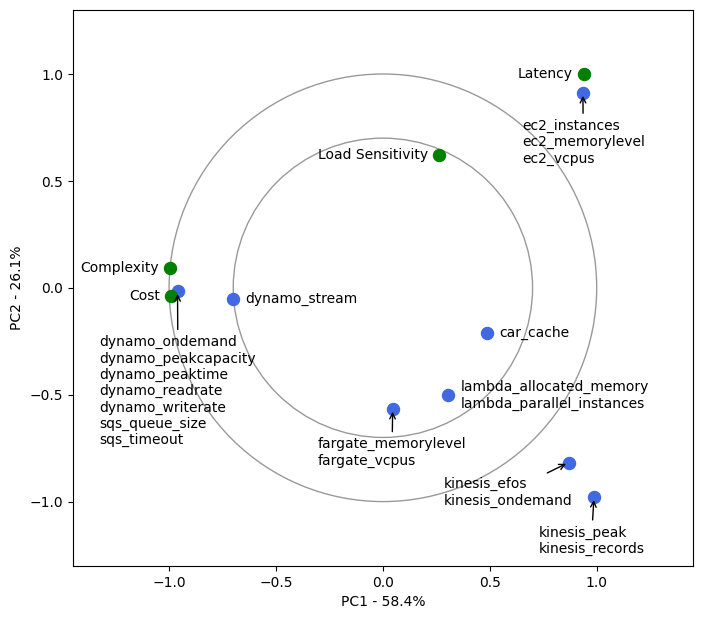